In [1]:
import numpy as np
from astropy.modeling.models import Sersic1D, Sersic2D
from astropy.modeling.core import Fittable1DModel, Parameter
import matplotlib.pyplot as plt
from astropy.visualization import hist
from scipy.stats import rv_continuous

In [2]:
def randomvariate(pdf, n, xmin, xmax):
    """
    Create random numbers according to an arbitrary PDF
    Uses the rejection method for generating random numbers derived from an arbitrary   
    probability distribution. For reference, see Bevington's book, page 84. Based on  
    rejection*.py.
    Usage:  
    >>> randomvariate(P,N,xmin,xmax)  
    where  
    P : probability distribution function from which you want to generate random numbers  
    N : desired number of random values  
    xmin,xmax : range of random numbers desired  
    
    Returns:   
    the sequence (ran,ntrials) where  
    ran : array of shape N with the random variates that follow the input P  
    ntrials : number of trials the code needed to achieve N  
   
    Here is the algorithm:  
    - generate x' in the desired range  
    - generate y' between Pmin and Pmax (Pmax is the maximal value of your pdf)  
    - if y'<P(x') accept x', otherwise reject  
    - repeat until desired number is achieved  
   
    Rodrigo Nemmen  
    Nov. 2011  
    """
    x = np.linspace(xmin, xmax, 10000)
    y = pdf(x)
    pmin = y.min()
    pmax = y.max()
    naccept = 0
    ntrial = 0
    ran = []
    while naccept < n:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(pmin, pmax)
        if y <= pdf(x):
            ran.append(x)
            naccept = naccept+1
                #  print pdf(x)
            ntrial = ntrial + 1

    ran = np.asarray(ran)
    return ran, ntrial
    

In [38]:
def rvs(pdf, n, xmin, xmax):
    """
    try it with numpy
    """
    x = np.linspace(xmin, xmax, 10000)
    y = pdf(x)
    pmin = y.min()
    pmax = y.max()
    rel_area =  (xmax -xmin)*(pmax - pmin) / np.trapz(y, x)
    print(rel_area)
    naccept = 0
    ntrial = 0
    ran = []
    m = int(len(x) * rel_area)*2
    X = np.random.uniform(xmin, xmax, m)
    Y = np.random.uniform(pmin, pmax, m)
    ran = X[Y<=pdf(X)]
    return ran[:n]

In [80]:
class Sersic1D(Fittable1DModel, rv_continuous):
    amplitude = Parameter(default=1)
    r_eff = Parameter(default=1)
    n = Parameter(default=4)
    _gammaincinv = None

    @classmethod
    def evaluate(cls, r, amplitude, r_eff, n):
        """One dimensional Sersic profile function."""

        if cls._gammaincinv is None:
            try:
                from scipy.special import gammaincinv
                cls._gammaincinv = gammaincinv
            except ValueError:
                raise ImportError('Sersic1D model requires scipy > 0.11.')

        return (amplitude * np.exp(
            -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)))
    
    def _pdf(self, r):
        s = Sersic1D(amplitude=self.amplitude, r_eff=self.r_eff, n=self.n)
        return s(r)


In [4]:
s = Sersic1D(amplitude=1, r_eff=5, n=4, name="sersic")

#s.rvs(size=100)

['a', 'b', 'badvalue', 'cdf', 'entropy', 'expect', 'extradoc', 'fit', 'freeze', 'interval', 'isf', 'logcdf', 'logpdf', 'logsf', 'mean', 'median', 'moment', 'name', 'nnlf', 'numargs', 'pdf', 'ppf', 'rvs', 'sf', 'shapes', 'stats', 'std', 'support', 'var', 'vecentropy', 'xtol']


(array([  5.,  13.,  44.,  82., 224., 223., 219., 122.,  50.,  18.]),
 array([-3.44260858, -2.83503623, -2.22746388, -1.61989153, -1.01231918,
        -0.40474683,  0.20282552,  0.81039788,  1.41797023,  2.02554258,
         2.63311493]),
 <a list of 10 Patch objects>)

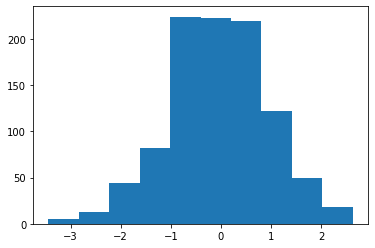

In [55]:
class sersic_gen(rv_continuous):
    "Gaussian distribution"
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)

class gaussian_gen(rv_continuous):
    "Gaussian distribution"
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)

gaussian = gaussian_gen(name='gaussian')
x  = np.arange(0,1,100)
g = gaussian
print([attr for attr in dir(g) if "_" not in attr]   )
x = g.rvs(size=1000)
hist(x)

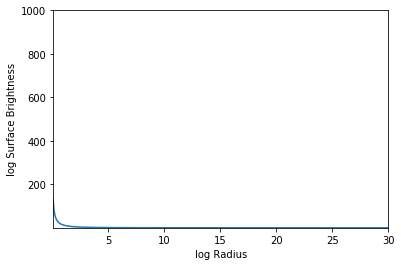

In [31]:
plt.figure()
plt.subplot(111) #, xscale='log', yscale='log')
s1 = Sersic1D(amplitude=1, r_eff=5, n=4)
r=np.arange(0, 100, .01)

plt.plot(r, s1(r))

plt.axis([1e-1, 30, 1e-2, 1e3])
plt.xlabel('log Radius')
plt.ylabel('log Surface Brightness')
#plt.text(.25, 1.5, 'n=1')
#plt.text(.25, 300, 'n=10')
#plt.xticks([])
#plt.yticks([])
plt.show()

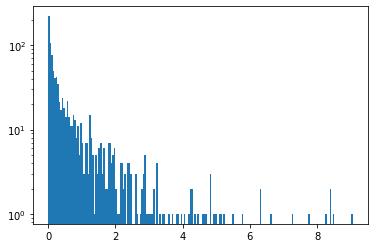

In [24]:
ran, ntrial = randomvariate(s1, 1000, xmin=0, xmax=10)

hist(ran, bins=200)
plt.semilogy()
plt.show()

292.0953538120333
(1000,)


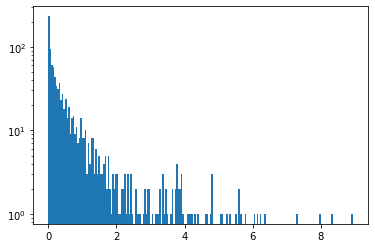

In [39]:
ran = rvs(s1, 1000, xmin=0, xmax=10)
print(ran.shape)
hist(ran, bins=200)
plt.semilogy()
plt.show()

------

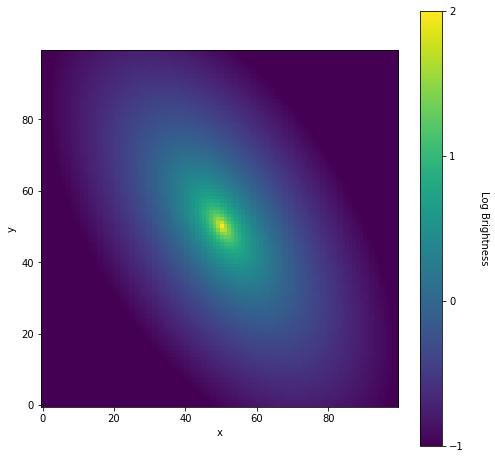

In [24]:
x,y = np.meshgrid(np.arange(100), np.arange(100))

mod = Sersic2D(amplitude = 1, r_eff = 25, n=4, x_0=50, y_0=50,
               ellip=.5, theta=-1)
img = mod(x, y)
log_img = np.log10(img)

plt.figure(figsize=(8,8))
plt.imshow(log_img, origin='lower', interpolation='nearest',
           vmin=-1, vmax=2)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

TypeError: __call__() missing 1 required positional argument: 'y'